<a href="https://colab.research.google.com/github/lisahqwang/ML-DL-CV/blob/main/Lisa_Unbiased_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unbiased estimation: Training phi and psi as two neural networks, enhancements and visualization
## Section author: Lisa (hw3082)

The Neural Network Approach builds upon the previous section, but with an increase of the dimensionality from 2 to 16.

- $\Phi(W)$ and $\Psi(x)$ will be trained to approximate $\operatorname{GELU}(W x)$.
- We'll build both as neural networks:
- $\Psi(x)$ will map the input vector $x \in \mathbb{R}^d$ to a feature space $\mathbb{R}^m$.
- $\Phi(W)$ will map the weight matrix $W \in \mathbb{R}^{d \times d}$ to a projection in $\mathbb{R}^{d \times m}$.



We would like to use backpropagation to train the model to reduce loss, which is the Mean Squared Error (MSE) between the output of the linearized model and the true GELU function:

Loss Function = $\mathbb{E}\left[\|\Phi(W) \Psi(x)-\operatorname{GELU}(W x)\|^2\right]$

And parameters are updated accordingly, shown below.


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Set dimensions
d = 16  # input/output size
m = 64  # intermediate size

# GELU activation
gelu = nn.GELU()

# Psi: Maps x ∈ ℝ^d → ℝ^m
class Psi(nn.Module):
    def __init__(self, d, m):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d, 2*m),
            nn.ReLU(),
            nn.Linear(2*m, m)
        )

    def forward(self, x):
        return self.net(x)  # Shape: (batch, m)

# Phi: Maps W ∈ ℝ^{d×d} → ℝ^{d×m}
class Phi(nn.Module):
    def __init__(self, d, m):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d * d, d*m),
            nn.ReLU(),
            nn.Linear(d*m , d * m)
        )
        self.d = d
        self.m = m

    def forward(self, W):
        W_flat = W.view(W.size(0), -1)  # Shape: (batch, d*d)
        out = self.net(W_flat)          # Shape: (batch, d*m)
        return out.view(-1, self.d, self.m)  # Shape: (batch, d, m)

# Full model
class LinearizedGELU(nn.Module):
    def __init__(self, d, m):
        super().__init__()
        self.psi = Psi(d, m)
        self.phi = Phi(d, m)

    def psi_visualize(self, x):
        return self.psi(x)

    def phi_visualize(self, W):
        return self.phi(W)

    def forward(self, x, W):
        psi_x = self.psi(x)             # (batch, m)
        phi_W = self.phi(W)             # (batch, d, m)
        y_hat = torch.bmm(phi_W, psi_x.unsqueeze(2)).squeeze(2)  # (batch, d)
        return y_hat

# Training loop (simple)
def train_model():
    model = LinearizedGELU(d, m)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    for step in range(2000):
        # Sample random input
        x = torch.randn(32, d)                 # batch of x
        W = torch.randn(32, d, d)              # batch of W
        y = gelu(torch.bmm(W, x.unsqueeze(2)).squeeze(2))  # GELU(Wx)

        # Forward pass
        y_hat = model(x, W)

        # Loss and optimize
        loss = loss_fn(y_hat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 100 == 0:
            print(f"Step {step}, Loss: {loss.item():.4f}")

train_model()

Step 0, Loss: 9.0547
Step 100, Loss: 4.5886
Step 200, Loss: 4.2912
Step 300, Loss: 4.6049
Step 400, Loss: 3.9265
Step 500, Loss: 3.9758
Step 600, Loss: 3.5844
Step 700, Loss: 4.6111
Step 800, Loss: 3.8559
Step 900, Loss: 3.7493
Step 1000, Loss: 4.0295
Step 1100, Loss: 3.4858
Step 1200, Loss: 3.4292
Step 1300, Loss: 3.6656
Step 1400, Loss: 2.8815
Step 1500, Loss: 3.1138
Step 1600, Loss: 2.5239
Step 1700, Loss: 2.9697
Step 1800, Loss: 2.7867
Step 1900, Loss: 2.9167


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# GELU function (standard)
def gelu(x):
    return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * x**3))) # Changed this line to convert the result of 2.0 / torch.pi to a PyTorch tensor before passing it to torch.sqrt()

# Ψ(x): Neural network mapping x ∈ ℝ^d → ℝ^m
class Psi(nn.Module):
    def __init__(self, d, m):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d, 2*m),
            nn.ReLU(),
            nn.Linear(2 * m, m)
        )

    def forward(self, x):
        return self.net(x)

# Φ(W): Neural network mapping W ∈ ℝ^{d×d} → ℝ^{d×m}
class Phi(nn.Module):
    def __init__(self, d, m):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d * d, d * m),
            nn.ReLU(),
            nn.Linear(d * m, d * m)
        )
        self.d = d
        self.m = m

    def forward(self, W):
        W_flat = W.view(W.size(0), -1)  # Flatten W to shape (batch, d*d)
        out = self.net(W_flat)          # Shape: (batch, d*m)
        return out.view(-1, self.d, self.m)  # Reshape to (batch, d, m)

# Linearized GELU model using Φ(W) and Ψ(x)
class LinearizedGELU(nn.Module):
    def __init__(self, d, m):
        super().__init__()
        self.psi = Psi(d, m)
        self.phi = Phi(d, m)

    #here we use Φ(W) and Ψ(x) classes declared above
    def forward(self, x, W):
        psi_x = self.psi(x)             # Shape: (batch, m)
        phi_W = self.phi(W)             # Shape: (batch, d, m)
        y_hat = torch.bmm(phi_W, psi_x.unsqueeze(2)).squeeze(2)  # Shape: (batch, d)
        return y_hat

# Training loop
def train_linearized(d=16, m=64, steps=2000):
    model = LinearizedGELU(d, m)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    for step in range(steps):
        # Sample random batch
        x = torch.randn(64, d)               # input vectors
        W = torch.randn(64, d, d)            # weight matrices

        # True target: GELU(Wx)
        Wx = torch.bmm(W, x.unsqueeze(2)).squeeze(2)  # Shape: (batch, d)
        y_true = gelu(Wx)

        # Predicted y'
        y_pred = model(x, W)
        #print("predicted y':", y_pred)

        # Loss
        loss = loss_fn(y_pred, y_true)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 100 == 0:
            print(f"Step {step}, Loss: {loss.item():.6f}")

    return model

# Run training
model = train_linearized()

Step 0, Loss: 8.132865
Step 100, Loss: 4.859593
Step 200, Loss: 4.698175
Step 300, Loss: 3.889102
Step 400, Loss: 3.215873
Step 500, Loss: 3.289052
Step 600, Loss: 3.240685
Step 700, Loss: 2.728224
Step 800, Loss: 2.701587
Step 900, Loss: 2.880007
Step 1000, Loss: 2.536137
Step 1100, Loss: 3.238026
Step 1200, Loss: 2.855365
Step 1300, Loss: 2.604251
Step 1400, Loss: 2.717557
Step 1500, Loss: 2.707349
Step 1600, Loss: 2.492784
Step 1700, Loss: 2.334332
Step 1800, Loss: 2.727004
Step 1900, Loss: 2.549173


# Plot the true GELU output

In this section, we visualize GELU(Wx) and the predicted output y over several test examples

Input dimension = 16

True GELU(Wx): tensor([[-6.2760e-02,  4.1252e-01,  2.8493e-01,  1.5295e+00,  4.9304e+00,
         -1.4997e-02, -1.0862e-01,  0.0000e+00,  8.2142e+00,  0.0000e+00,
         -1.6450e-01,  7.6910e-01,  2.2444e+00, -1.6990e-01, -8.7216e-03,
         -7.0014e-02],
        [-1.9141e-04, -1.2892e-01, -3.0320e-06, -7.6147e-07, -1.5366e-01,
          3.4390e+00,  7.6314e-02,  8.2904e+00,  5.2371e+00, -9.0779e-06,
          0.0000e+00, -4.5040e-02, -1.3177e-01, -1.6975e-01, -1.6807e-01,
          5.5057e+00],
        [ 1.9795e+00,  3.0484e+00,  3.7261e+00,  4.0782e+00, -4.4037e-06,
          4.0455e+00, -7.3614e-02, -2.4222e-02, -1.1893e-02,  5.2273e+00,
         -2.1993e-06,  0.0000e+00,  0.0000e+00,  2.5128e+00, -3.4981e-04,
          3.0577e+00],
        [ 4.2861e+00, -1.9446e-04, -2.4657e-03,  2.6679e+00, -7.6160e-07,
          3.2370e+00,  6.7444e+00,  6.2867e+00,  0.0000e+00,  5.0339e+00,
          7.7262e+00,  1.7632e+00, -1.4869e-01,  5.5862e+00, -7.3911e-05,
         -4.9523e-06]])
Pred

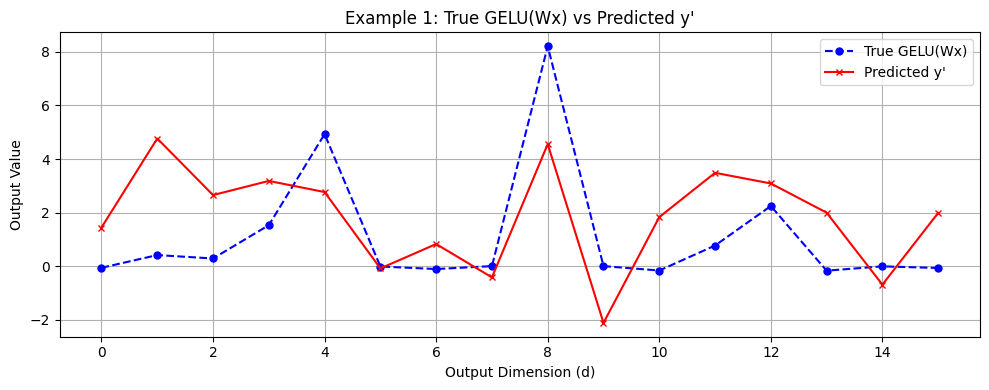

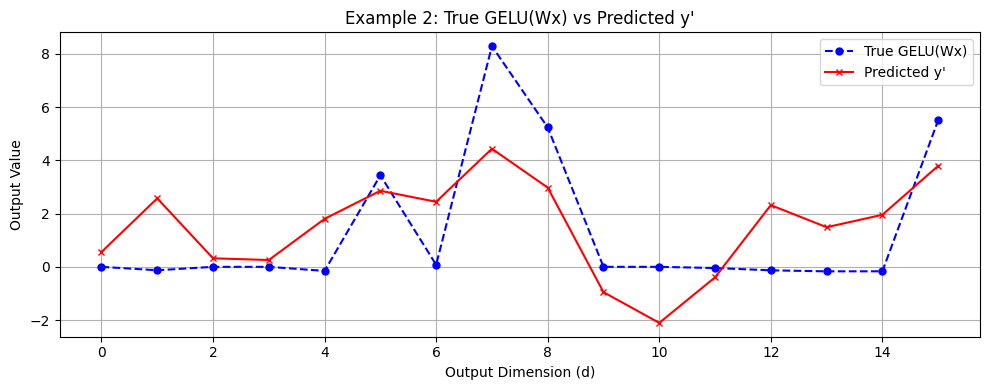

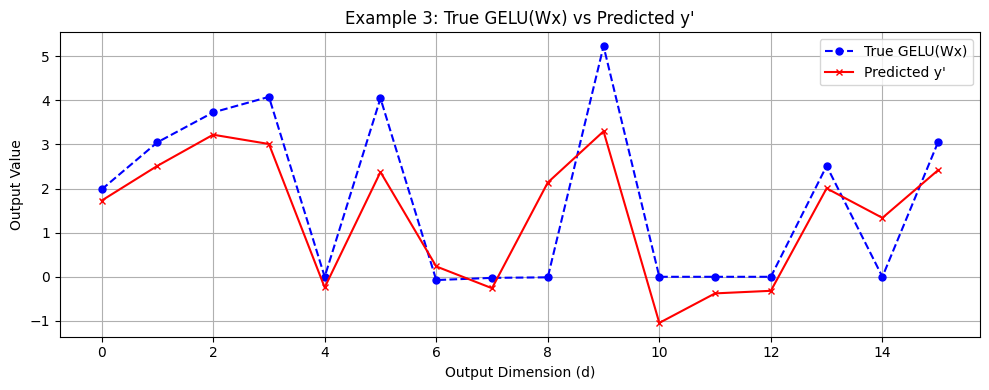

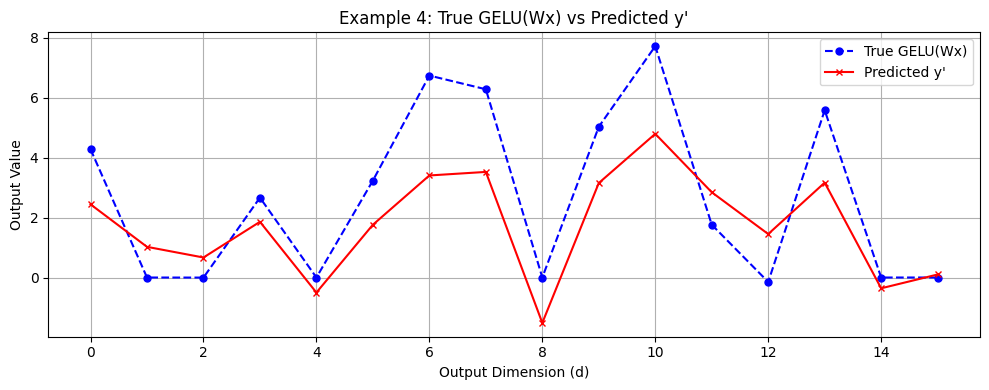

In [7]:
import matplotlib.pyplot as plt
import torch

def visualize_approximation(model, num_examples=4):
    model.eval()

    d = 16  # input dimension
    m = 64  # feature space dimension (from model)

    # Generate random test data
    x = torch.randn(num_examples, d)  # input vectors
    W = torch.randn(num_examples, d, d)  # weight matrices

    with torch.no_grad():
        # True target: GELU(Wx)
        Wx = torch.bmm(W, x.unsqueeze(2)).squeeze(2)  # shape: (num_examples, d)
        y_true = gelu(Wx)  # GELU(Wx) output

        # Predicted y'
        y_pred = model(x, W)  # shape: (num_examples, d)

        print("True GELU(Wx):", y_true)
        print("Predicted y':", y_pred)


    # Plot the comparison between true and predicted values
    for i in range(num_examples):
        plt.figure(figsize=(10, 4))

        # Plot true GELU(Wx) vs predicted y'
        plt.plot(y_true[i].numpy(), label="True GELU(Wx)", marker='o', markersize=5, linestyle='--', color='b')
        plt.plot(y_pred[i].numpy(), label="Predicted y'", marker='x', markersize=5, linestyle='-', color='r')

        # Title and labels
        plt.title(f"Example {i+1}: True GELU(Wx) vs Predicted y'")
        plt.xlabel("Output Dimension (d)")
        plt.ylabel("Output Value")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        plt.show()

# Visualize after training
visualize_approximation(model)

# **Model Convergence**
In this section, the loss curve decreases and gradually converges to the true GELU approximation

Step 0, Loss: 8.337980
Average loss: 8.337980
Step 100, Loss: 5.081269
Average loss: 5.656705
Step 200, Loss: 4.921795
Average loss: 5.225353
Step 300, Loss: 3.662830
Average loss: 4.846624
Step 400, Loss: 3.634544
Average loss: 4.575528
Step 500, Loss: 3.224701
Average loss: 4.353251
Step 600, Loss: 3.398057
Average loss: 4.175131
Step 700, Loss: 3.200974
Average loss: 4.027485
Step 800, Loss: 2.768836
Average loss: 3.903732
Step 900, Loss: 2.988559
Average loss: 3.795690
Step 1000, Loss: 2.707418
Average loss: 3.704715
Step 1100, Loss: 2.774051
Average loss: 3.618367
Step 1200, Loss: 2.901551
Average loss: 3.545447
Step 1300, Loss: 3.066357
Average loss: 3.482556
Step 1400, Loss: 2.647005
Average loss: 3.424828
Step 1500, Loss: 2.558138
Average loss: 3.373445
Step 1600, Loss: 2.523971
Average loss: 3.326733
Step 1700, Loss: 2.370945
Average loss: 3.285204
Step 1800, Loss: 2.852171
Average loss: 3.246917
Step 1900, Loss: 2.479608
Average loss: 3.212173


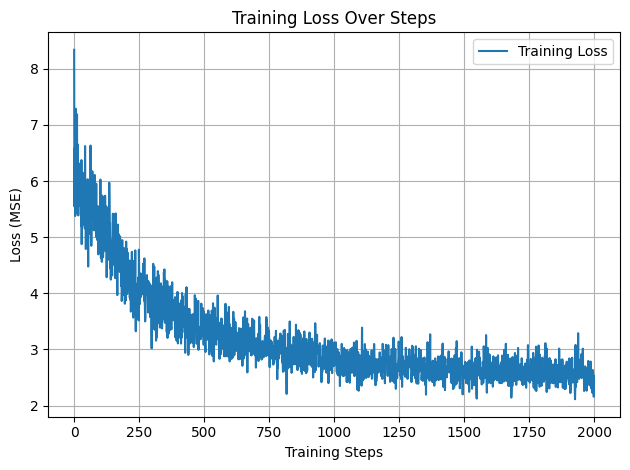

The final training loss is around 2.013


In [13]:
import matplotlib.pyplot as plt

# Modified training loop to track loss at each step
def train_linearized_with_loss_tracking(d=16, m=64, steps=2000):
    model = LinearizedGELU(d, m)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    # List to store loss values at each step
    loss_history = []

    for step in range(steps):
        # Sample random batch
        x = torch.randn(64, d)               # input vectors
        W = torch.randn(64, d, d)            # weight matrices

        # True target: GELU(Wx)
        Wx = torch.bmm(W, x.unsqueeze(2)).squeeze(2)  # Shape: (batch, d)
        y_true = gelu(Wx)

        # Predicted y'
        y_pred = model(x, W)

        # Calculate loss
        loss = loss_fn(y_pred, y_true)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Tracking loss
        loss_history.append(loss.item())

        if step % 100 == 0:
            print(f"Step {step}, Loss: {loss.item():.6f}")
            print(f"Average loss: {sum(loss_history) / len(loss_history):.6f}")

    return model, loss_history

# Train the model and track loss
model, loss_history = train_linearized_with_loss_tracking()

#for loss in loss_history:
    #loss_average = sum(loss_history) / len(loss_history)
    #print(f"Average loss: {loss_average:.6f}")

# Plot loss history
plt.plot(loss_history, label="Training Loss")
plt.title("Training Loss Over Steps")
plt.xlabel("Training Steps")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("The final training loss is ~3.2")

# **Conclusion**

We can conclude from this unbiased estimation section that psi and phi are learnable functions with a reduceable loss function, with a dimension higher than 2.